In [15]:
import numpy as np
from numpy import cos, sin, arctan2 as atan, sqrt, pi as π, sign, log
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
from scipy.spatial.transform import Rotation
from scipy.integrate import quad
from scipy.special import ellipk as ellK,  ellipe as ellE
from scipy.special import ellipkinc as ellK_inc,  ellipeinc as ellE_inc
from scipy.constants import mu_0 as μ0

import pycoilib as pycoil
from pycoilib.inductance import calc_M_2arcs
from pycoilib.shape import Arc, Line, Circle

plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('lines', linewidth=2)
plt.rc('font', size=9)

_vec_x=np.array([1.,0.,0.])
_vec_y=np.array([0.,1.,0.])
_vec_z=np.array([0.,0.,1.])
_vec_0=np.array([0.,0.,0.])

# Fonctions utiles

In [4]:
def rand(n=1):
    return np.array([random.random() for i in range(n)])

def random_vec_on_sphere(n=1):
    φ = rand(n) *2*π
    θ = np.arccos( rand(n)*2-1 )
    
    n_vec = np.array([ [np.cos(θ_i)*np.sin(φ_i),
                        np.sin(θ_i)*np.sin(φ_i),
                        np.cos(φ_i)] for θ_i, φ_i in zip(θ, φ) ] )
    return n_vec

# Boucle secondaire complètement random

In [6]:
# Init 
R_p =1
Rmax = 10
n = 1000

# Propriétés aléatoires du secondaire
random.seed(1)   
R_s = rand(n)*(10-0.1)*R_p + 0.1*R_p
vec_n = random_vec_on_sphere(n)
s0 = np.cbrt(rand(n))*Rmax

vec_s0_u=random_vec_on_sphere(n)
vec_s0 = np.array( [ s0_u_i*s0_i for s0_u_i, s0_i in zip(vec_s0_u, s0)] )

# Début calcul
M_our = []
M_bab = []
loop1 = Circle(R_p)
for R_si, vec_ni, vec_s0i in zip(R_s, vec_n, vec_s0):
    loop2 = Circle.from_normal(R_si, vec_s0i, vec_ni)

    m_our, err = pycoil.inductance.calc_M(loop1, loop2) 
    m_bab, err = pycoil.inductance.calc_M_Babic(R_p, R_si, vec_s0i, vec_ni)

    M_our.append(m_our)
    M_bab.append(m_bab)

M_our = np.array(M_our)
M_bab = np.array(M_bab) 


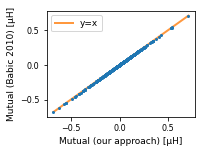

In [12]:
# affichage
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure(figsize=(7.5/2.54, 5.5/2.54))
ax = plt.gca()

xy = [min(M_our.min(), M_bab.min())*1e6, max(M_our.max(), M_bab.max())*1e6 ] # droite y=x
ax.plot(xy,xy, alpha=0.8, c=colors[1])

ax.plot(M_our*1e6, M_bab*1e6, 'o',c=colors[0],  markersize=2) #data
ax.legend(["y=x"])
ax.set_xlabel(r"Mutual (our approach) [μH]")
ax.set_ylabel(r"Mutual (Babic 2010) [μH]")


fig.tight_layout()
fig.savefig("BabicVSus.png", dpi=300)
plt.show()

# plt.plot(M_our-M_bab,"*",markersize=2)


# ax.set_xlabel(r"Inductance (our approach) [mm]")
# ax.set_ylabel(r"Mutual inductance [μH]")
# plt.show()

# plt.hist(M_our-M_bab, bins=50)
# plt.plot()

# 2 Arcs, dont le 2e complètement random

In [22]:
# Init 
R_p =1
Rmax = 10
n = 1000

# Propriétés aléatoires du secondaire
random.seed(1)   
R_s = rand(n)*(10-0.1)*R_p + 0.1*R_p
vec_z = random_vec_on_sphere(n)
s0 = np.cbrt(rand(n))*Rmax

vec_s0_u=random_vec_on_sphere(n)
vec_s0 = np.array( [ s0_u_i*s0_i for s0_u_i, s0_i in zip(vec_s0_u, s0)] )

arc_angle = rand(n)*2*π

vec_t = random_vec_on_sphere(n)

vec_x = np.zeros_like(vec_t)
for i, (ti, zi) in enumerate(zip(vec_t, vec_z)):
    tmp = ti-(ti@zi)*zi
    vec_x[i] = tmp/np.sqrt(tmp@tmp)

vec_y = np.cross(vec_z, vec_x)
# Début calcul
M_arcs = []
M_loop = []

arc1 = Arc(_vec_0, R_p, 2*π, _vec_x, _vec_y, _vec_z)
loop = Circle(R_p)

for R_si, vec_zi, vec_s0i, vec_yi, vec_xi, arc_angle_i in zip(R_s, vec_z, vec_s0, vec_y, vec_x, arc_angle):
    arc2 = Arc(vec_s0i, R_si,arc_angle_i,vec_xi, vec_yi, vec_zi)

    m_arcs, err = pycoil.inductance.calc_M_2arcs(arc2, arc1) 
    m_loop, err = pycoil.inductance.calc_M_arcNloop(arc2, loop)

    M_arcs.append(m_arcs)
    M_loop.append(m_loop)

M_arcs = np.array(M_arcs)
M_loop = np.array(M_loop) 

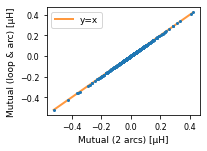

In [23]:
# Affichage
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure(figsize=(7.5/2.54, 5.5/2.54))
ax = plt.gca()

xy = [min(M_loop.min(), M_arcs.min())*1e6, max(M_arcs.max(), M_loop.max())*1e6 ] # droite y=x
ax.plot(xy,xy, alpha=0.8, c=colors[1])

ax.plot(M_arcs*1e6, M_loop*1e6, 'o', c=colors[0],  markersize=2) #data
ax.legend(["y=x"])
ax.set_xlabel(r"Mutual (2 arcs) [μH]")
ax.set_ylabel(r"Mutual (loop & arc) [μH]")

fig.tight_layout()
fig.savefig("arcNloop VS 2arcs.png", dpi=300)
plt.show()

